In [1]:
using SpiDy
using NPZ
using DataFrames
using CSV
using ProgressMeter
using Random
using Statistics
using LinearAlgebra
using Plots

########################
########################

Δt = .2
N = 1000
tspan = (0., N*Δt)
saveat = (0:1:N)*Δt

matrix = IsoCoupling(1)

T = .01
noise = ClassicalNoise(T);

theta = pi * 1/2

s0 = [0, 1, cos(theta)]
s0 = s0 ./ norm(s0)

J0 = 1.
JH = Nchain(1, J0)

nruns = 10000

10000

In [2]:
α = 10. # 0.16
ω0 = 7. # 1.4
Γ = 5. # 0.5

J = LorentzianSD(α, ω0, Γ) # coloring the noise

println("Starting...")
progress = Progress(nruns);

sols_ohm = zeros(nruns, length(saveat), 3)

Threads.@threads for i in 1:nruns
    bfields = [bfield(N, Δt, J, noise),
               bfield(N, Δt, J, noise),
               bfield(N, Δt, J, noise)];
    sol = diffeqsolver(s0, tspan, J, bfields, matrix; JH=JH, saveat=saveat);
    sols_ohm[i, :, :] = transpose(sol[:, :])
    next!(progress)
end

solavg_ohm = mean(sols_ohm, dims=1)[1, :, :];
solstd_ohm = std(sols_ohm, dims=1)[1, :, :];

Starting...


Progress: 100%|█████████████████████████████████████████| Time: 0:01:116:19


In [3]:
α = 0.16
ω0 = 1.4
Γ = 0.5

J = LorentzianSD(α, ω0, Γ) # coloring the noise

println("Starting...")
progress = Progress(nruns);

sols_col = zeros(nruns, length(saveat), 3)

Threads.@threads for i in 1:nruns
    bfields = [bfield(N, Δt, J, noise),
               bfield(N, Δt, J, noise),
               bfield(N, Δt, J, noise)];
    sol = diffeqsolver(s0, tspan, J, bfields, matrix; JH=JH, saveat=saveat);
    sols_col[i, :, :] = transpose(sol[:, :])
    next!(progress)
end

solavg_col = mean(sols_col, dims=1)[1, :, :];
solstd_col = std(sols_col, dims=1)[1, :, :];

Starting...


Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


In [4]:
using HypothesisTests
using LaTeXStrings

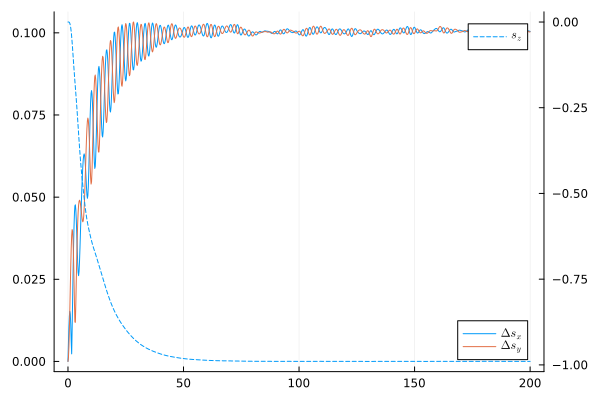

In [5]:
plot(saveat, solstd_col[:, 1], label=L"\Delta s_x")
plot!(saveat, solstd_col[:, 2], label=L"\Delta s_y")

axis = twinx()
plot!(axis, saveat, solavg_col[:, 3], label=L"s_z", ls=:dash)

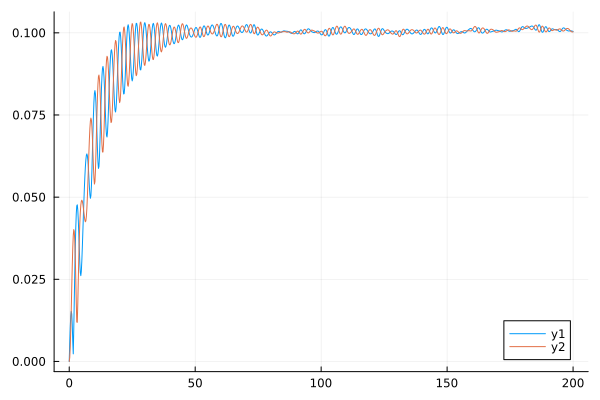

In [6]:
plot(saveat, solstd_col[:, 1])
plot!(saveat, solstd_col[:, 2])

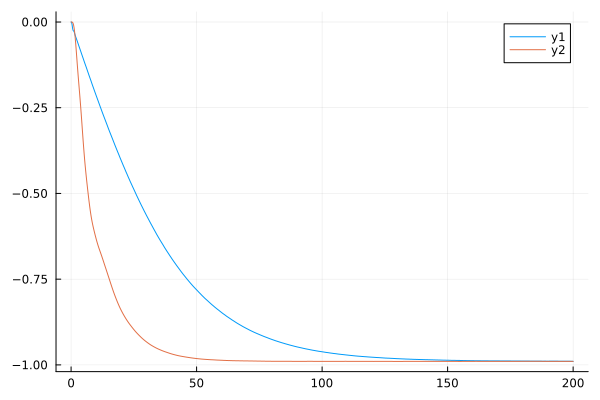

In [7]:
plot(saveat, solavg_ohm[:, 3])
plot!(saveat, solavg_col[:, 3])

In [8]:
projected_ohm = zeros(nruns, length(saveat), 2)

normalized_avg = [normalize(vec(row)) for row in eachrow(solavg_ohm)]

Threads.@threads for i in 1:length(saveat)
    n = normalized_avg[i, :][1]

    u = normalize(cross(n, [0,0,1]))
    v = cross(u, n)

    for j in 1:nruns
        b = sols_ohm[j, i, :]
        proj = dot(b, n) * n
        b_ort = b - proj

        projected_ohm[j, i, 1] = dot(u,b)
        projected_ohm[j, i, 2] = dot(v,b)
    end
end

In [9]:
projected_col = zeros(nruns, length(saveat), 2)

normalized_avg = [normalize(vec(row)) for row in eachrow(solavg_col)]

Threads.@threads for i in 1:length(saveat)
    n = normalized_avg[i, :][1]

    u = normalize(cross(n, [0,0,1]))
    v = cross(u, n)

    for j in 1:nruns
        b = sols_col[j, i, :]
        proj = dot(b, n) * n
        b_ort = b - proj

        projected_col[j, i, 1] = dot(u,b)
        projected_col[j, i, 2] = dot(v,b)
    end
end

In [10]:
JB_ohm = zeros(N)
for i in 1:N
    JB_ohm[i] = HypothesisTests.JarqueBeraTest(projected_ohm[:, i, 1]).JB
end

In [11]:
JB_col = zeros(N)
for i in 1:N
    JB_col[i] = HypothesisTests.JarqueBeraTest(projected_col[:, i, 1]).JB
end

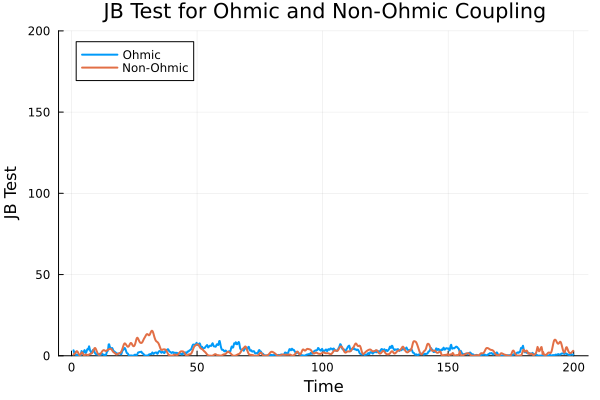

In [12]:
plot(saveat[5:N], JB_ohm[5:N], title="JB Test for Ohmic and Non-Ohmic Coupling", label="Ohmic", linewidth=2, xlabel="Time", ylabel="JB Test", legend=:topleft, ylimits=(0, 200))
plot!(saveat[5:N], JB_col[5:N], label="Non-Ohmic", linewidth=2)

In [13]:
right_axis = twinx()

plot!(right_axis, saveat, solavg_ohm[:, 3], label="Ohmic", ls=:dash, ylabel=L"S_z", ylimits=(-1.5, 1.5))
plot!(right_axis, saveat, solavg_col[:, 3], label="Non-Ohmic", ls=:dash)

savefig("./90.png")

"/work/benstem/SpiDySims/runs/90.png"

In [14]:
HypothesisTests.JarqueBeraTest(projected_col[:, 125, 1])

Jarque-Bera normality test
--------------------------
Population details:
    parameter of interest:   skewness and kurtosis
    value under h_0:         "0 and 3"
    point estimate:          "-0.05774318582232778 and 2.9724957756989863"

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.0531

Details:
    number of observations:         10000
    JB statistic:                   5.87233


[ Info: Saved animation to /work/benstem/SpiDySims/runs/90_hist_ohm.gif


Plots.AnimatedGif("/work/benstem/SpiDySims/runs/90_hist_ohm.gif")
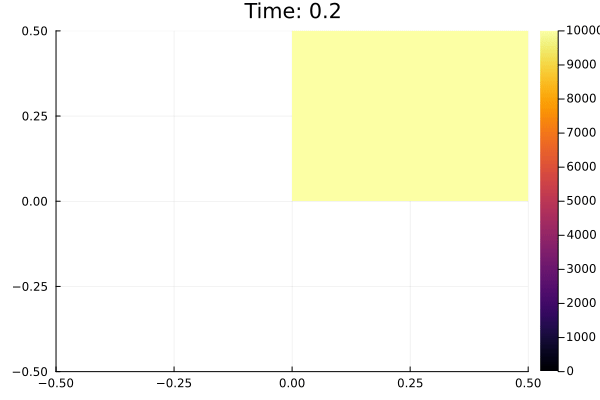

In [15]:
# Function to create a single histogram plot
function plot_histogram(i)
    histogram2d(projected_ohm[:, i, 1], projected_ohm[:, i, 2], nbins=50, xlims=(-.5, .5), ylims=(-.5, .5), title="Time: $(i/5)")
end

# Create the animation
anim = @animate for i in 1:200
    plot_histogram(i)
end

# Save the animation as a gif
gif(anim, "90_hist_ohm.gif", fps=10)


[ Info: Saved animation to /work/benstem/SpiDySims/runs/90_hist_col.gif


Plots.AnimatedGif("/work/benstem/SpiDySims/runs/90_hist_col.gif")
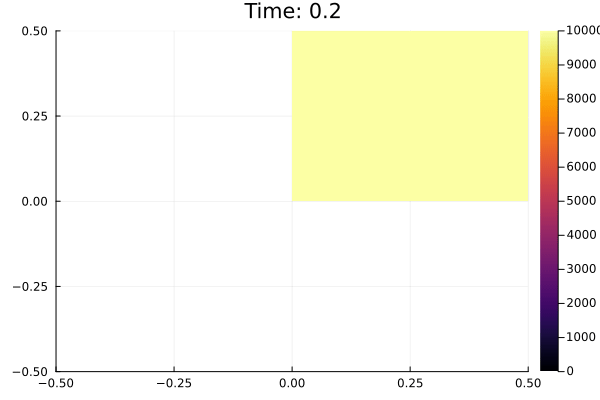

In [16]:
# Function to create a single histogram plot
function plot_histogram(i)
    histogram2d(projected_col[:, i, 1], projected_col[:, i, 2], nbins=50, xlims=(-.5, .5), ylims=(-.5, .5), title="Time: $(i/5)")
end

# Create the animation
anim = @animate for i in 1:200
    plot_histogram(i)
end

# Save the animation as a gif
gif(anim, "90_hist_col.gif", fps=10)